# Fig 2 - introducing mixtures

## Overview:

<!-- N sprays most important thing for resistance

Effect of changes to initial distributions - variance and mean

(maths in appendix proves it)

And resistance increases with dose

Then can say simple things about resistance management, but yield and econ more complex (figs 2 onwards address)

FIG:
1. Mean of dist vs severity in diff cases (doses / sprays)
2. Mean of dist vs n sprays/dose
3. Variance vs change in following year or vs mean in year X -->

## Required data:

Uses `cluster/f2_mixtures.submit` which produces `outputs/fig2/300.csv`.

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib widget

In [2]:
import pandas as pd

import seaborn as sns

import numpy as np
import matplotlib.pyplot as plt

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px


from plots2.fns import (
    standard_layout,
    corner_annotations_colwise,
    corner_annotations_rowwise,
    get_text_annotation
)

# from poly2.utils import get_dist_mean, edge_values
# from poly2.run import simulations_run, no_joblib_simulations_run
# from poly2.config import Config

In [3]:
COLZ = sns.color_palette('muted').as_hex()

# Plot

## Data

In [128]:
df_in = (
    pd.read_csv('../outputs/combined/fig2/fig2.csv')
    .assign(econ = lambda df: -20 + 117.14*df.yld - 2*32.4*(df.dose_A + df.dose_B))
)

df_in.head(3)

,run,dose_A,dose_B,year,sev,yld,econ
0,0,0.0,0.0,1,19.967677,8.810391,1012.049227
1,0,0.0,0.0,2,19.967677,8.810391,1012.049227
2,0,0.0,0.0,3,19.967677,8.810391,1012.049227


In [129]:
df_use = (
    df_in
    .loc[lambda df: df.year==15]
    .drop(['run', 'year'], axis=1)
    # .assign(econ = lambda df: -20 + 117.14*df.yld - 2*32.4*(df.dose_A + df.dose_B))
    # .assign(yld = lambda df: df.yld.cumsum())
)

df_use

,dose_A,dose_B,sev,yld,econ
14,0.0,0.00,19.967677,8.810391,1012.049227
29,0.0,0.05,16.191119,9.111461,1044.076588
44,0.0,0.10,15.404984,9.176324,1048.434579
59,0.0,0.15,14.984318,9.211327,1049.294837
74,0.0,0.20,14.732125,9.232409,1048.524353
...,...,...,...,...,...
6554,1.0,0.80,8.154657,9.805956,1012.029731
6569,1.0,0.85,8.053849,9.815074,1009.857758
6584,1.0,0.90,7.959500,9.823615,1007.618303
6599,1.0,0.95,7.870391,9.831690,1005.324133


In [130]:
df_use2 = (
    df_in.join(        
        df_in
        .drop(['run', 'year'], axis=1)
        .groupby(['dose_A', 'dose_B'])
        .cumsum()
        .rename(columns = lambda x: 'cum_'+str(x))
    )
    .assign(
        av_sev = lambda df: df.cum_sev/df.year,
        av_yld = lambda df: df.cum_yld/df.year,
        av_econ = lambda df: df.cum_econ/df.year,
    )
    .loc[lambda df: df.year==15]
)

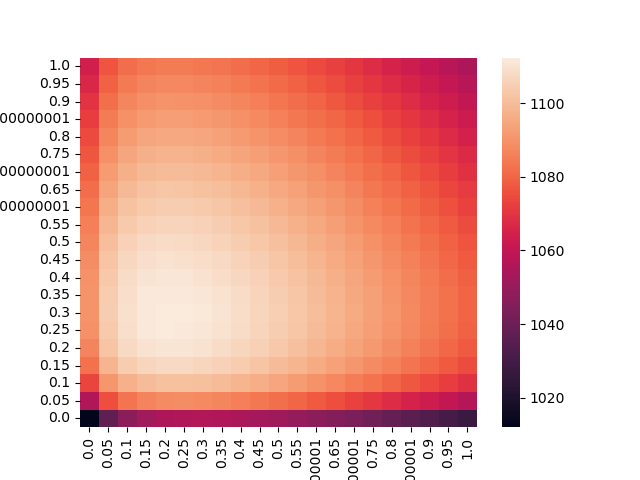

In [133]:
f, ax = plt.subplots()

sns.heatmap(
    data=df_use2.pivot(index='dose_B', columns='dose_A', values='av_econ'),
    ax=ax,
)

ax.invert_yaxis()

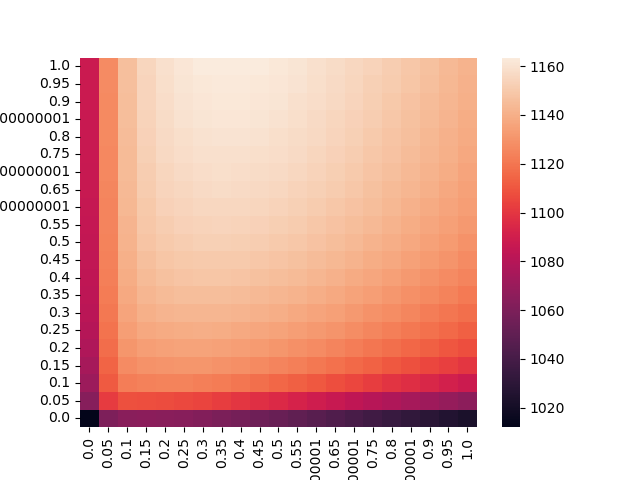

In [96]:
f, ax = plt.subplots()

sns.heatmap(
    data=df_use.pivot(index='dose_B', columns='dose_A', values='econ'),
    ax=ax,
)

ax.invert_yaxis()

## Fig fn

In [398]:
def fig1(df):
    
    fig = make_subplots(
        rows=3,
        cols=1,
        vertical_spacing=0.15,
    )
        
    # dose_colors = px.colors.sequential.Plotly3
    dose_colors = px.colors.sequential.Viridis
    
    cols = ['red', 'blue', 'black']
    
    for spray, color in zip([1,2,3], cols):
        by_spray = df.loc[df.sprays==spray]
        
        for ind, dose in enumerate(by_spray.dose.unique()):
            
            dash = 'solid'
            
            by_spray_and_dose = by_spray.loc[lambda dd: dd.dose==dose]
            
            plural = 's' if spray!=1 else ''
            
            name_this_spray = f'{spray} spray{plural}'
            
            
            if spray==2:
                color_subplot_3 = dose_colors[ind]
                
                name_this_dose = f'{dose=}'
                
                t_3 = go.Scatter(
                    x=by_spray_and_dose.total_sprays,
                    y=by_spray_and_dose.fung_mean,
                    mode='lines+markers',
                    name=name_this_dose,
                    marker=dict(color=color_subplot_3, size=4),
                    line=dict(color=color_subplot_3, dash=dash),
                    # opacity=0.5,
                    showlegend=False
                )

                fig.add_trace(t_3, row=3, col=1)
            
            
            
            
            if dose!=1:
                continue
            
            
            t_1 = go.Scatter(
                    x=by_spray_and_dose.fung_mean,
                    y=by_spray_and_dose.sev,
                    mode='lines+markers',
                    name=name_this_spray,
                    marker=dict(color=color, size=4),
                    line=dict(color=color, dash=dash),
                )

            fig.add_trace(t_1, row=1, col=1)
            
            
            
            t_2 = go.Scatter(
                x=by_spray_and_dose.total_sprays,
                y=by_spray_and_dose.fung_mean,
                mode='lines+markers',
                name=name_this_spray,
                marker=dict(color=color, size=4),
                line=dict(color=color, dash=dash),
                showlegend=False
            )
    
            fig.add_trace(t_2, row=2, col=1)
    
    
    
    
    
    fig.update_layout(standard_layout(True, height=800))
    
    fig.update_layout(legend=dict(x=0, y=1.12, orientation='h', font=dict(size=12)))
    
    corners = corner_annotations_colwise(
        3, 1,
        1.05, 0,
        0.38, 0
    )
    
                        
    annotz = (
        corners + [
            get_text_annotation(31, 0.106, 'Dose=0.1', xanchor='left',
                    yanchor='middle', size=12, color=dose_colors[0], refs='3'),
            # Use -2 because -1 is harder to see
            get_text_annotation(31, 0.70, 'Dose=1', xanchor='left',
                    yanchor='middle', size=12, color=dose_colors[8], refs='3')
        ]
    )   
    
    fig.update_layout(annotations=annotz)
    
    
    
    # X axis    
    # xrange = [0,15]
    
    fig.update_xaxes(title_text='Trait mean',
                     row=1, col=1,
                     showgrid=False)
    
    fig.update_xaxes(title_text='Number of applications',
                     row=2, col=1,
                     showgrid=False)
    
    fig.update_xaxes(title_text='Number of applications',
                     row=3, col=1,
                     showgrid=False)
    
    
    # Y axis    
    fig.update_yaxes(title_text='Disease severity (%)',
                     row=1, col=1,
                     showgrid=False)
    
    fig.update_yaxes(title_text='Trait mean',
                         row=2, col=1,
                         showgrid=False)
    
    fig.update_yaxes(title_text='Trait mean',
                         row=3, col=1,
                         showgrid=False)

    return fig

## FIG

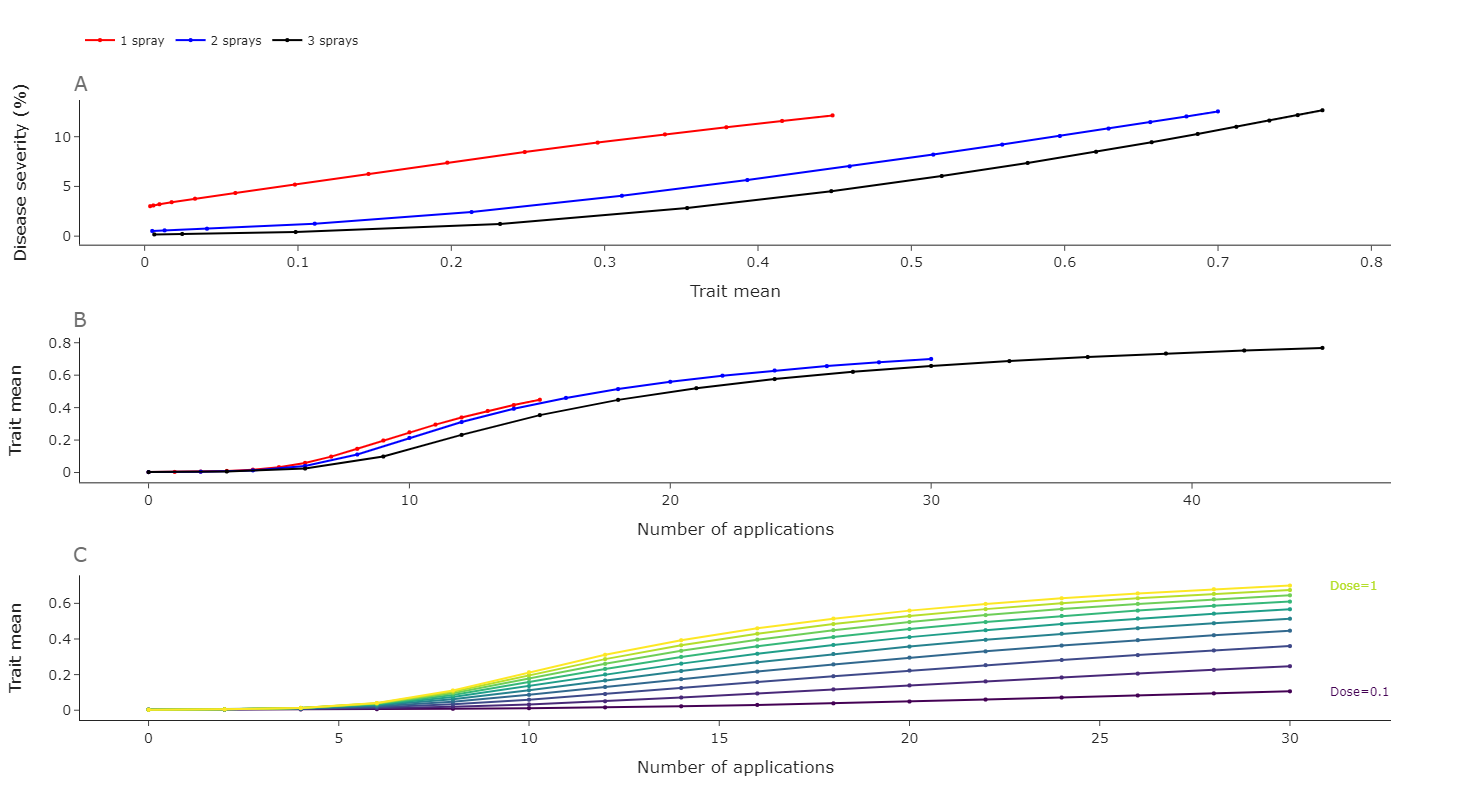

In [399]:
f = fig1(df_use)

f.show()

More applications gives slightly slower relative increase:

- I think linked to density dependence - with density dependence off, no mutation, no fung decay `B` looked perfect
- Host growth has an effect because final and first sprays occur when lower `S`
- Fung decay vs not didn't do too much I think
- Mutation high changed things but low didn't

Probably worth various scans with figure `B`.

The variance thing sort of works, best with no density dependence but within season effects cause problems - using values from the middle of the year gives a pretty good outcome but still not perfect when `sprays=3`.

In [400]:
f.write_image('../figures/paper/fig1.png')

# Testing

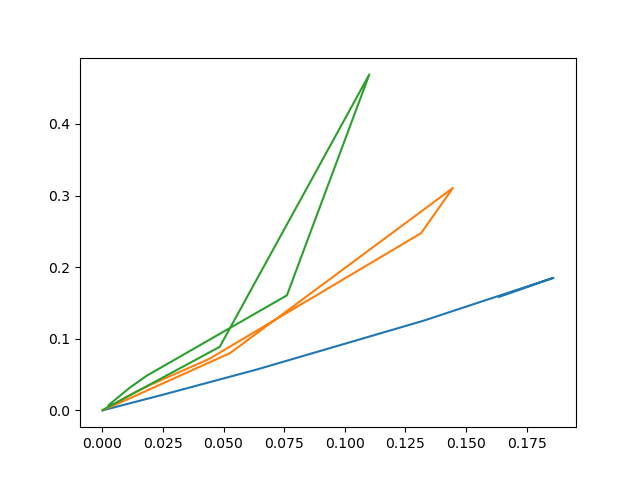

In [257]:
f, ax = plt.subplots()


for ii in range(1,4):
    df2 = (
        df_use
        .loc[lambda x: ((x.sprays==ii) & (x.dose==1))]
        .assign(middle_var = lambda df: df.fung_var + df.fung_var.shift(-1))
    )

    # ax.plot(df2.fung_var, df2.mean_diff)
    ax.plot(df2.middle_var, df2.mean_diff)

### Various effects to explore

We have the following differences between the mathematical model and the simulations:
- host growth
- mutation
- density dependence
- fungicide decay

It seems that mutation does nothing, but the others all have small effects. We vary which of these are present and explore the results below.

### Host growth off

In [358]:
nhg = (
    pd.read_csv('../outputs/combined/fig1/no_host_growth.csv')
    .assign(total_sprays = lambda df: df.sprays * df.year)
)

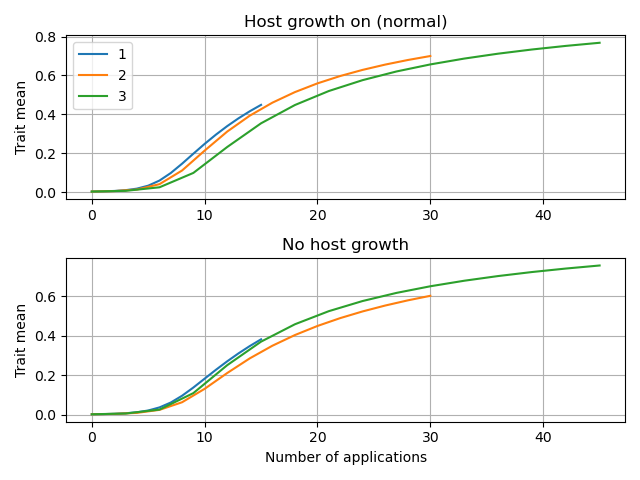

In [377]:
f, ax = plt.subplots(2,1)

for spray in [1,2,3]:
    tp = df_use.loc[lambda df: df.sprays==spray].loc[lambda df: df.dose==1]
    tpnhg = nhg.loc[lambda df: df.sprays==spray]
    
    ax[0].plot(tp.total_sprays, tp.fung_mean, label=spray)
    ax[1].plot(tpnhg.total_sprays, tpnhg.fung_mean, label=spray)

ax[0].set_title('Host growth on (normal)')
ax[1].set_title('No host growth')

ax[0].grid()
ax[1].grid()

ax[1].set_xlabel('Number of applications')

ax[0].set_ylabel('Trait mean')
ax[1].set_ylabel('Trait mean')

ax[0].legend()

f.tight_layout()

Turning host growth off increases the selection for 3 sprays and means pretty close to selection only depends on number applications.

- 1 spray at T2
- 2 sprays at T2, T3
- 3 sprays at T1, T2, T3

#### Host growth on

With host growth, 3 sprays means fungicide present when host either not grown yet, or began senesence. So selection is reduced. 

Selection maximal for sprays=1 where host at its maximum.

This makes sense.

#### No host growth
With no host growth, 2 has lowest selection (`1>3>2`). Why is this?

Trade off in following effects:
- fungicide decay - seemingly gives `1>2>3` (see diff between no density dependence with and without fung decay - perfectly aligned vs `1>2>3`)
- density dependence - makes `3` higher selection. Not sure why makes `1>2`?

##### Fungicide decay

To do with overlap in concentration? Because season ends, spray at T3 doesn't have time to end either (doesn't fully decay before `t=2515`).

##### Density dependence

`1>2` because second spray has smaller `S` than first spray. 

To do with the amount of `S`.

If `S=S1,S2,S3` at `T1,T2,T3`, in the absence of control, we have `S1>S2>S3`, because disease is reducing `S` with time.

In the 2 case, have an extra spray when `S=S3` so reduced selection compared to only spraying when `S=S2`.

In the 3 case, we have a spray at `S=S1`, so maximal selection. Then `S2*` is higher than would have been without spraying. Final spray have `S3*` which is likely lower than `S2`, but it is higher than `S3`... that is, in the 3 case we have higher `S` for the first two sprays, and certainly higher `S` at `T3` relative to the 2 spray case (but probably not so bad as in the 1 case).

### No host growth or fung decay

Tests effect of density dependence.

NB here mutation on - but in general this does nothing (see below).

In [390]:
nhgfd = (
    pd.read_csv('../outputs/combined/fig1/no_host_growth_or_fung_decay.csv')
    .assign(total_sprays = lambda df: df.sprays * df.year)
)

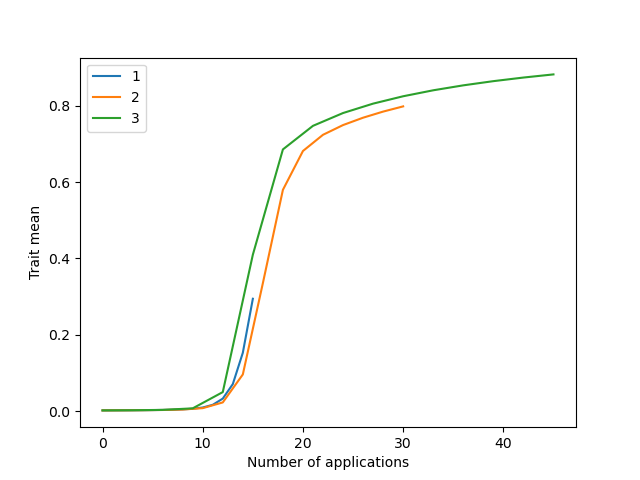

In [391]:
f, ax = plt.subplots()

for spray in [1,2,3]:
    tp = nhgfd.loc[lambda df: df.sprays==spray]
    
    ax.plot(tp.total_sprays, tp.fung_mean, label=spray)

ax.set_xlabel('Number of applications')
ax.set_ylabel('Trait mean')

ax.legend()

### No density dependence and no host growth

NB here mutation on.

Gets pretty close to aligning.

Have `1>2>3`. Suspect this is due to fungicide decay?

In [386]:
ndd = (
    pd.read_csv('../outputs/combined/fig1/no_density_dependence.csv')
    .assign(total_sprays = lambda df: df.sprays * df.year)
)

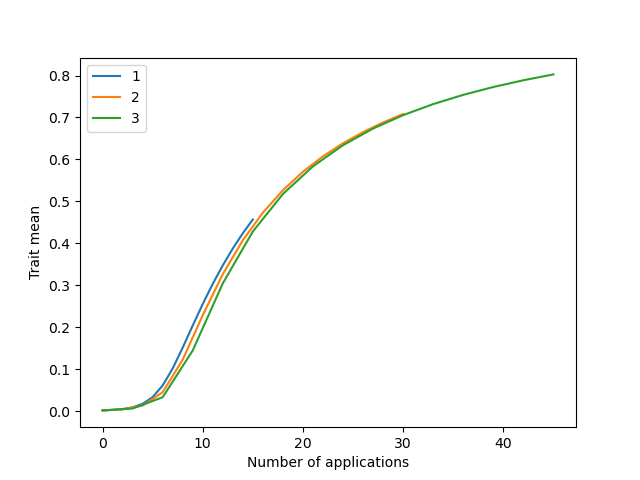

In [387]:
f, ax = plt.subplots()

for spray in [1,2,3]:
    tp = ndd.loc[lambda df: df.sprays==spray]
    
    ax.plot(tp.total_sprays, tp.fung_mean, label=spray)

ax.set_xlabel('Number of applications')
ax.set_ylabel('Trait mean')

ax.legend()

### No density dep, host growth or fungicide decay

This matches basically perfectly.

In [388]:
nddfd = (
    pd.read_csv('../outputs/combined/fig1/no_density_dep_or_fung_decay.csv')
    .assign(total_sprays = lambda df: df.sprays * df.year)
)

Host Growth Off!!!
FUNGICIDE NO LONGER DECAYS!!!


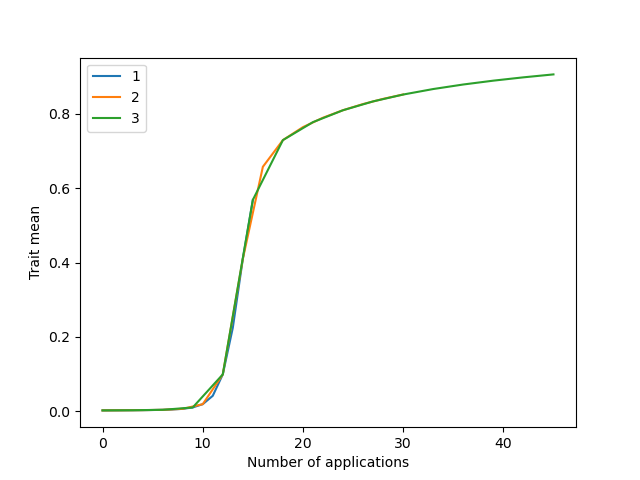

In [389]:
f, ax = plt.subplots()

for spray in [1,2,3]:
    tp = nddfd.loc[lambda df: df.sprays==spray]
    
    ax.plot(tp.total_sprays, tp.fung_mean, label=spray)

ax.set_xlabel('Number of applications')
ax.set_ylabel('Trait mean')

ax.legend()

### Mutation does nothing

Would think that for `sprays=1` mutation happens more per spray because more generations (higher `beta` on average) and longer to do it - more years. 

But mutation effectively does nothing because `p` so small (see below)

In [378]:
m0 = (
    pd.read_csv('../outputs/combined/fig1/m_0.csv')
    .assign(total_sprays = lambda df: df.sprays * df.year)
)

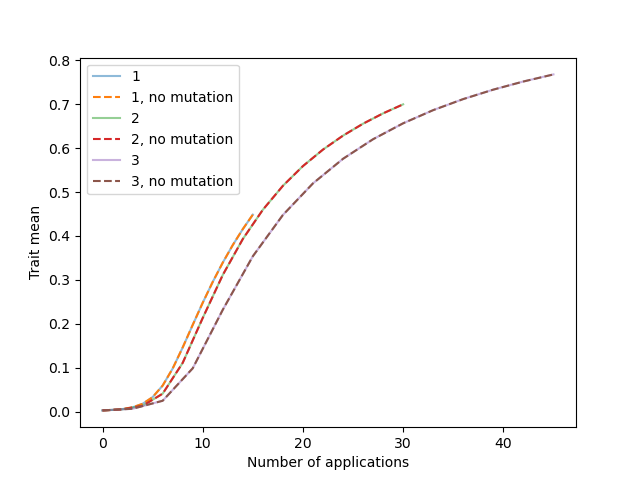

In [382]:
f, ax = plt.subplots()

for spray in [1,2,3]:
    tp = df_use.loc[lambda df: df.sprays==spray].loc[lambda df: df.dose==1]
    tpm0 = m0.loc[lambda df: df.sprays==spray]
    
    ax.plot(tp.total_sprays, tp.fung_mean, label=spray, alpha=0.5)
    ax.plot(tpm0.total_sprays, tpm0.fung_mean, label=f'{spray}, no mutation', ls='--')

ax.set_xlabel('Number of applications')

ax.set_ylabel('Trait mean')

ax.legend()

### No mutation, no host growth

Again, essentially does nothing

In [384]:
m0_nhg = (
    pd.read_csv('../outputs/combined/fig1/m0_nhg.csv')
    .assign(total_sprays = lambda df: df.sprays * df.year)
)

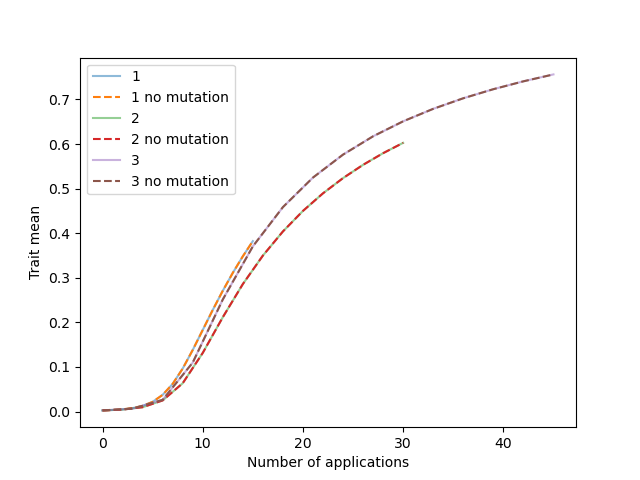

In [385]:
f, ax = plt.subplots()

for spray in [1,2,3]:
    tpm0 = m0_nhg.loc[lambda df: df.sprays==spray].loc[lambda df: df.dose==1]
    tpnhg = nhg.loc[lambda df: df.sprays==spray]
    
    ax.plot(tpnhg.total_sprays, tpnhg.fung_mean, label=spray, alpha=0.5)
    ax.plot(tpm0.total_sprays, tpm0.fung_mean, label=f'{spray} no mutation', ls='--')

ax.set_xlabel('Number of applications')

ax.set_ylabel('Trait mean')

ax.legend()